In [15]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

In [16]:
conn = sqlite3.connect('./percentage_1.sqlite3')
c = conn.cursor()
per_data = pd.read_sql('SELECT * FROM percentage', con=conn)
c.close()

In [ ]:
reverse_data = per_data[::-1]
reverse_data = reverse_data.reset_index(drop=True)
reverse_data

In [19]:
percentage = reverse_data['percentage'].values
percentage

array([100, 100, 100, ...,  85,   1,   1])

In [78]:
seq_len = 50      # 최근 50일의 예측점수를 관측치로 설정
sequence_length = seq_len + 1 # 하루가 지날 때마다 관측치 구간도 하루씩 이동

result = []
for index in range(len(percentage) - sequence_length):      # predictive_value: 언론사의 예측률 변수
    result.append(percentage[index: index + sequence_length])

# result

In [79]:
normalized_data = []
for window in result:
    for p in window:
      normalized_window = [((float(p) / float(window[0])) - 1) for p in window]   # 데이터 정규화
      normalized_data.append(normalized_window)
result = np.array(normalized_data)

# split train and test data

row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((146192, 50, 1), (16243, 50, 1))

In [80]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))   # 관측치: 50일
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=20)

Epoch 1/20
572/572 [==============================] - 104s 182ms/step - loss: 3.1906 - val_loss: 663.6127
Epoch 2/20
572/572 [==============================] - 104s 182ms/step - loss: 2.5271 - val_loss: 621.9422
Epoch 3/20
572/572 [==============================] - 104s 181ms/step - loss: 2.4501 - val_loss: 703.1644
Epoch 4/20
572/572 [==============================] - 104s 182ms/step - loss: 1.9841 - val_loss: 620.2171
Epoch 5/20
572/572 [==============================] - 104s 182ms/step - loss: 1.5575 - val_loss: 644.4352
Epoch 6/20
572/572 [==============================] - 104s 182ms/step - loss: 2.1699 - val_loss: 642.9892
Epoch 7/20
572/572 [==============================] - 104s 182ms/step - loss: 1.5446 - val_loss: 674.4485
Epoch 8/20
572/572 [==============================] - 104s 182ms/step - loss: 1.6463 - val_loss: 643.4598
Epoch 9/20
572/572 [==============================] - 104s 182ms/step - loss: 2.7161 - val_loss: 639.1790
Epoch 10/20
572/572 [=========================

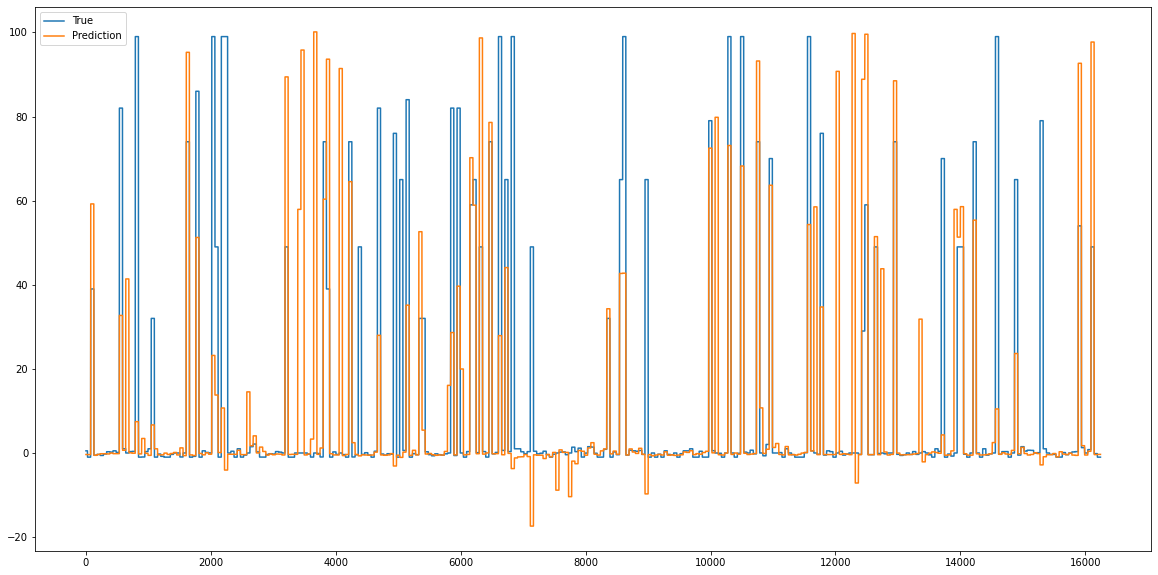

In [88]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [89]:
model.save('./press_weight.h5')